# Does everything to run entropy and creates slurm files to submit

Goal is 4 chains k=2-8.

**Creates mpgl file from GL in vcf**.   
Issue due to running FreeBayes in ddocent

    - test that GL for tetraploids different than diploids

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
root = '/data/gpfs/assoc/denovo/tfaske/sagebrush/denovo/SNPcall/test/'

In [4]:
cd $root

/data/gpfs/assoc/denovo/tfaske/sagebrush/denovo/SNPcall/test


### Create mgpl & pntest files with associated dir   

Uses custom R script to do so

In [5]:
ent_dir =os.path.join(root,'entropy')
assert ent_dir

In [6]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/denovo/SNPcall/test/entropy


In [7]:
!gunzip 'good_snps.recode.vcf.gz'

In [8]:
%load_ext rpy2.ipython

In [10]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/denovo/SNPcall/test/entropy/')

R[write to console]: Loading required package: LEA



In [11]:
%%R
vcf <- read.vcfR("good_snps.recode.vcf", verbose = FALSE)
pos <- read.table("good_snps.recode.vcf.012.pos")
pos_ID <- paste(pos$V1,pos$V2,sep = ':')

gl <- extract.gt(vcf, element = 'GL')

In [14]:
%%R

## check out GL

#gl[1:5,]

NULL


In [15]:
%%R
#### triallelic snps for some fucking reason. Remove ####
mpgl_fix <- function(gl){
    if(is.na(gl)){
        gls <- c('0 0 0')
    }else{
        gl0 <- abs(as.numeric(unlist(strsplit(as.character(gl),split = ',')))[1])
        gl1 <- abs(as.numeric(unlist(strsplit(as.character(gl),split = ',')))[2])
        gl2 <- abs(as.numeric(unlist(strsplit(as.character(gl),split = ',')))[3])
        gls <- paste(gl0,gl1,gl2,sep=' ')
    }
    return(gls) 
}
system.time(mpgl <- apply(gl,1:2,mpgl_fix))

   user  system elapsed 
 14.465   0.138  14.602 


In [16]:
%%R
#check
print(gl[1:5,1:2])
print(mpgl[1:5,1:2])

                        AT2_EW_36             AT2_HC_2             
dDocent_Contig_7210_3   "0,-10.235,-113.523"  "0,-10.8371,-118.58" 
dDocent_Contig_8888_13  "0,-2.32277,-59.9048" "0,-4.51545,-50.2905"
dDocent_Contig_9056_22  "0,-4.51169,-104.465" "0,-6.62378,-63.5967"
dDocent_Contig_9585_38  "0,-7.63798,-188.808" "0,-12.3422,-135.369"
dDocent_Contig_10590_18 "0,-3.82792,-70.6066" "0,-7.22472,-80.2429"
                        AT2_EW_36           AT2_HC_2           
dDocent_Contig_7210_3   "0 10.235 113.523"  "0 10.8371 118.58" 
dDocent_Contig_8888_13  "0 2.32277 59.9048" "0 4.51545 50.2905"
dDocent_Contig_9056_22  "0 4.51169 104.465" "0 6.62378 63.5967"
dDocent_Contig_9585_38  "0 7.63798 188.808" "0 12.3422 135.369"
dDocent_Contig_10590_18 "0 3.82792 70.6066" "0 7.22472 80.2429"


In [17]:
%%R
rownames(mpgl) <- pos_ID
dim(mpgl)
write.table(mpgl,'mpgl.txt',quote=F,col.names = F) 

In [18]:
%%R
### pntest_mean ###
mean_gl <- function(GP){
  gp0 <- abs(as.numeric(unlist(strsplit(as.character(GP),split = ',')))[1])
  gp1 <- abs(as.numeric(unlist(strsplit(as.character(GP),split = ',')))[2])
  gp2 <- abs(as.numeric(unlist(strsplit(as.character(GP),split = ',')))[3])
  gps <- c(gp0,gp1,gp2)
  gps <- 10 ^ (gps/-10) #converts likelihood
  mean <- (gps[2] + (2*gps[3]))/sum(gps) #weights from 0 to 2
  return(mean) 
}

system.time(pntest_mean <- apply(gl,1:2,mean_gl))

   user  system elapsed 
 12.049   0.020  12.069 


In [19]:
%%R 
rownames(pntest_mean) <- pos_ID
dim(pntest_mean)

write.table(pntest_mean,'pntest_mean.txt',quote=F)

In [20]:
%%R
pntest_mean[1:5,]

                         AT2_EW_36   AT2_HC_2  AT2_VM_5  AT2_YB_79   AT4_DS_2
dDocent_Contig_7210:3   0.08653502 0.07618590 0.1111111 0.09217307 0.35515521
dDocent_Contig_8888:13  0.36939036 0.26121589 0.4684465 0.11111111 0.01092793
dDocent_Contig_9056:22  0.26137098 0.17870041 0.2612729 0.07618590 0.04368968
dDocent_Contig_9585:38  0.14695199 0.05510171 0.6438195 0.46923069 0.69997400
dDocent_Contig_10590:18 0.29288554 0.15928561 0.2353517 0.96464683 0.03252808
                          AT4_SL_2   AT4_WT_2   AV2_FP_6  AV2_GC_9 AV2_TF_156
dDocent_Contig_7210:3   0.06822464 0.04232418 0.01341969 0.1277354 0.06278003
dDocent_Contig_8888:13  0.45402664 0.45402659 0.27873888 0.3033797 0.03465320
dDocent_Contig_9056:22  0.66793163 0.12015727 0.39688694 0.1787377 0.09242385
dDocent_Contig_9585:38  0.70022297 0.42087174 0.04922630 0.4770148 0.59334268
dDocent_Contig_10590:18 0.15928563 0.88534981 0.89267556 0.9914768 0.43348519
                          AV2_UV_2   AV4_JU_5    AV4_LM_5  AV4_L

### Create ldak files in R

In [200]:
%%R
#create Pop_ID file 

indv<-read.table("good_snps.recode.vcf.012.indv",sep="\t")

Sp <- rep(NA,times=nrow(indv))
Pop <- rep(NA,times=nrow(indv))
ID <- rep(NA,times=nrow(indv))
All <- rep(NA,times=nrow(indv))
for (i in 1:nrow(indv)){
  Sp[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[1]
  Pop[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[2]
  ID[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[3]
  All[i] <- as.character(indv$V1[i])
}
Pop_ID<- data.frame(Sp,Pop,ID,All)

write.csv(Pop_ID,'Pop_ID.csv',row.names = F)

In [201]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(pntest_mean))

    PC1     PC2     PC3     PC4     PC5 
0.19047 0.06927 0.01935 0.01444 0.01190 


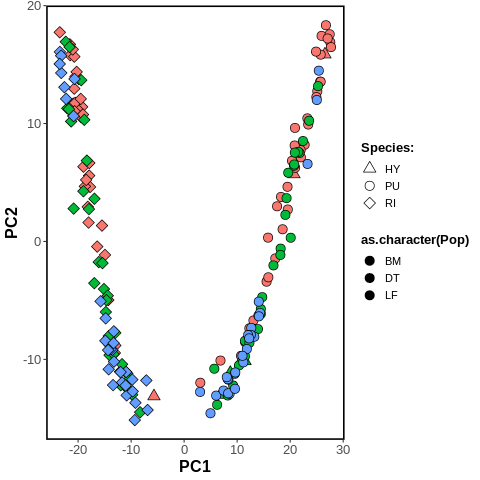

In [202]:
%%R
pca_plot_df <- cbind(Pop_ID,pca_df)
ggplot(data = pca_plot_df, aes(x=PC1,y=PC2,
                          fill=as.character(Pop),
                          shape=as.character(Sp))) +
  geom_point(colour='black',size = 4) + 
  #xlab(paste("PC",1," (",pve[1]*100,"%)",sep="")) + ylab(paste("PC",2," (",pve[2]*100,"%)",sep="")) +
  #scale_fill_npg(name = 'Population:') +
  scale_shape_manual(name = 'Species:',values=c(24,21,23)) + 
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

In [203]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [204]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(pntest_mean)

df <- t(Header)
dims <- paste(dim(pntest_mean)[2],dim(pntest_mean)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [205]:
!head entropy_header.txt

194 6343                                                                                                                                                                                                 
BM_1 BM_3 BM_4 DT_2 DT_3 BM_1 BM_2 BM_3 BM_4 BM_5 BM_6 BM_7 BM_9 BM_10 BM_12 BM_13 BM_14 BM_15 BM_16 BM_17 BM_18 BM_19 BM_20 BM_21 BM_22 BM_23 BM_24 BM_25 BM_26 BM_27 BM_28 BM_29 BM_30 BM_31 BM_35 BM_36 BM_37 BM_38 BM_39 BM_40 DT_1 DT_2 DT_3 DT_4 DT_5 DT_6 DT_7 DT_8 DT_20 DT_21 DT_22 DT_23 DT_24 DT_25 DT_26 DT_27 DT_31 DT_32 DT_33 DT_34 DT_35 DT_36 DT_37 DT_38 DT_39 DT_40 DT_41 DT_42 DT_43 DT_44 DT_45 DT_46 LF_21 LF_22 LF_23 LF_24 LF_25 LF_26 LF_27 LF_28 LF_29 LF_2 LF_30 LF_31 LF_32 LF_33 LF_34 LF_35 LF_36 LF_37 LF_38 LF_39 LF_40 LF_41 LF_42 LF_43 LF_5 LF_99 BM_1 BM_2 BM_3 BM_4 BM_5 BM_6 BM_8 BM_9 BM_10 BM_11 BM_12 BM_13 BM_14 BM_15 BM_16 BM_17 BM_18 BM_19 BM_20 BM_21 BM_22 BM_23 BM_24 BM_25 BM_27 BM_28 BM_29 BM_30 BM_31 BM_32 BM_33 BM_34 BM_35 DT_1 DT_2 DT_3 DT_4 DT_5 DT_6 DT_7 DT_8 DT_

In [206]:
!cat entropy_header.txt mpgl.txt > entropy.mpgl

In [207]:
!head entropy.mpgl

194 6343                                                                                                                                                                                                 
BM_1 BM_3 BM_4 DT_2 DT_3 BM_1 BM_2 BM_3 BM_4 BM_5 BM_6 BM_7 BM_9 BM_10 BM_12 BM_13 BM_14 BM_15 BM_16 BM_17 BM_18 BM_19 BM_20 BM_21 BM_22 BM_23 BM_24 BM_25 BM_26 BM_27 BM_28 BM_29 BM_30 BM_31 BM_35 BM_36 BM_37 BM_38 BM_39 BM_40 DT_1 DT_2 DT_3 DT_4 DT_5 DT_6 DT_7 DT_8 DT_20 DT_21 DT_22 DT_23 DT_24 DT_25 DT_26 DT_27 DT_31 DT_32 DT_33 DT_34 DT_35 DT_36 DT_37 DT_38 DT_39 DT_40 DT_41 DT_42 DT_43 DT_44 DT_45 DT_46 LF_21 LF_22 LF_23 LF_24 LF_25 LF_26 LF_27 LF_28 LF_29 LF_2 LF_30 LF_31 LF_32 LF_33 LF_34 LF_35 LF_36 LF_37 LF_38 LF_39 LF_40 LF_41 LF_42 LF_43 LF_5 LF_99 BM_1 BM_2 BM_3 BM_4 BM_5 BM_6 BM_8 BM_9 BM_10 BM_11 BM_12 BM_13 BM_14 BM_15 BM_16 BM_17 BM_18 BM_19 BM_20 BM_21 BM_22 BM_23 BM_24 BM_25 BM_27 BM_28 BM_29 BM_30 BM_31 BM_32 BM_33 BM_34 BM_35 DT_1 DT_2 DT_3 DT_4 DT_5 DT_6 DT_7 DT_8 DT_

In [208]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy


In [209]:
!mkdir shdir

In [210]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '4-00:00:00' #time limit 4
cpus = 4 #to prevent hammering one node
mem_cpu = 8000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7,8]
chains = 4

In [211]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [212]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [213]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k4_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_entropy_k4_c4.sh',
 '/data/gpfs/assoc/denovo/tf

In [214]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [215]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/connie/ch2/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [216]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [217]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy


In [218]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5',
 './entropy_k8_c1.hdf5',
 './entropy_k8_c2.hdf5',
 './entropy_k8_c3.hdf5',
 './entropy_k8_c4.hdf5']

In [219]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [220]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [221]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k8_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k8_c3.txt',
 './DIC_k8_c1.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k8_c2.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt']

In [222]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 2600471.09
Effective number of parameters: 5163022.60
Model DIC: 7763493.69


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 2430625.28
Effective number of parameters: 20804812.24
Model DIC: 23235437.52


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 2600440.97
Effective number of parameters: 5061892.05
Model DIC: 7662333.02


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 2598877.62
Effective number of parameters: 54007070.06
Model DIC: 56605947.68


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 2598817.39
Effective number of parameters: 29035478.94
Model DIC: 31634296.32


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: samples = 5

In [223]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,7763493.69,4
1,7,23235437.52,2
2,2,7662333.02,1
3,6,56605947.68,1
4,3,31634296.32,2


In [224]:
dic_df.to_csv('dic_list.csv')

In [225]:
dic_sum = dic_df.groupby('k').describe().DIC

In [226]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,7.75904283e+06,1.07505472e+05,7662333.02,7.69253020e+06,7.73304481e+06,7.79955744e+06,7.90774868e+06
7,4.0,1.56167843e+08,9.43921143e+07,23235437.52,1.26688424e+08,1.80339450e+08,2.09818870e+08,2.40757036e+08
5,4.0,4.49283355e+08,4.33087349e+08,56484031.51,8.34191389e+07,4.56633293e+08,8.22497509e+08,8.27382800e+08
8,4.0,5.71312241e+08,3.68673795e+08,272083887.31,3.40153224e+08,4.58962373e+08,6.90121390e+08,1.09524033e+09
3,4.0,7.38152283e+08,4.89003864e+08,31634296.32,6.24771907e+08,8.89044477e+08,1.00242485e+09,1.14288588e+09
4,4.0,7.70237112e+08,1.15648985e+09,7594790.78,1.14112311e+07,3.10342626e+08,1.06916851e+09,2.45266841e+09
6,4.0,1.04022615e+09,1.07821246e+09,56605947.68,3.39476892e+08,8.01321841e+08,1.50207110e+09,2.50165499e+09


In [227]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [228]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt


file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 194, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 194, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 194, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 194, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 194, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

In [229]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 194, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 194, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 194, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 194, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 194, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

### make slurm script to make gprob file

    use all k and chains to make gprob

In [230]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy


In [231]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,6,7,8]

In [232]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [233]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [234]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k7.sh',
 '/data/gpfs/assoc/denovo/tfaske/connie/ch2/entropy/shdir/run_gprob_k8.sh']

In [235]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [236]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [237]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5',
 '../entropy_k8_c*hdf5']

In [238]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 ../entropy_k8_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [239]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [240]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [241]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/milkweed/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt